In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (150, 150, 3))
conv_base.summary()

Using TensorFlow backend.



58892288/58889256 [==============================] - 60s 1us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
____________________________________________________________

In [3]:
import os 
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/home/starflyyy/Deep learning/Dog_vs_cats/split_into_train_vali_test'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale = 1. / 255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape = (sample_count, 4, 4, 512))
    labels = np.zeros(shape = (sample_count))
    generator = datagen.flow_from_directory(directory, target_size = (150, 150), batch_size = batch_size, class_mode = 'binary')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i+1) * batch_size] = features_batch
        labels[i * batch_size : (i+1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [4]:
train_features, train_labels = extract_features(train_dir, 8000)
validation_features, validation_labels = extract_features(validation_dir, 2500)
test_features, test_labels = extract_features(test_dir, 2000)

Found 16000 images belonging to 2 classes.

Found 5000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [5]:
train_features = np.reshape(train_features, (8000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (2500, 4 * 4 * 512))
test_features = np.reshape(test_features, (2000, 4 * 4 * 512))

In [6]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation = 'relu', input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = optimizers.RMSprop(lr = 2e-5), loss = 'binary_crossentropy', metrics = ['acc'])
history = model.fit(train_features, train_labels, epochs = 30, batch_size = 20, validation_data = (validation_features, validation_labels))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 8000 samples, validate on 2500 samples
Epoch 1/30
8000/8000 [==============================] - 5s 569us/step - loss: 0.4443 - acc: 0.7834 - val_loss: 0.3102 - val_acc: 0.8756
Epoch 2/30
8000/8000 [==============================] - 2s 300us/step - loss: 0.3079 - acc: 0.8629 - val_loss: 0.2713 - val_acc: 0.8928
Epoch 3/30
8000/8000 [==============================] - 2s 310us/step - loss: 0.2690 - acc: 0.8821 - val_loss: 0.2515 - val_acc: 0.8996
Epoch 4/30
8000/8000 [==============================] - 2s 251us/step - loss: 0.2430 - acc: 0.8957 - val_loss: 0.2413 - val_acc: 0.9044
Epoch 5/30
8000/8000 [==============================] - 2s 258us/step - loss: 0.2264 - acc: 0.9046 - val_loss: 0.2391 - val_acc: 0.9036
Epoch 6/30
8000/8000 [==============================] - 2s 274us/step - loss: 0.2169 - acc: 0.9089 - val_loss: 0.2310 - val_acc: 0.9100
Epoch 7/30
8000/8000 [====================

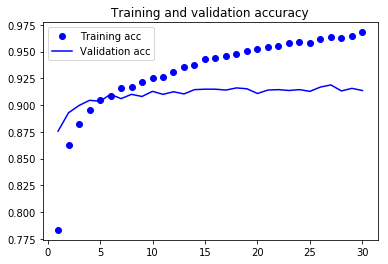

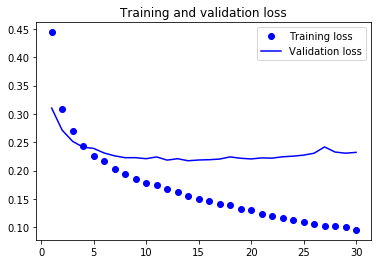

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, 31)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [9]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [12]:
len(model.trainable_weights)

30

In [13]:
conv_base.trainable = False
len(model.trainable_weights)

4

In [14]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(rescale = 1. / 255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')

test_datagen = ImageDataGenerator(rescale = 1. /255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size = (150, 150), batch_size = 20, class_mode = 'binary')
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size = (150, 150), batch_size = 20, class_mode = 'binary')

model.compile(loss = 'binary_crossentropy', optimizer = optimizers.RMSprop(lr = 2e-5), metrics = ['acc'])

history = model.fit_generator(train_generator, steps_per_epoch = 400, epochs = 30, validation_data = validation_generator, validation_steps = 125)

Found 16000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/30
400/400 [==============================] - 78s 195ms/step - loss: 0.4945 - acc: 0.7741 - val_loss: 0.3861 - val_acc: 0.8592
Epoch 2/30
400/400 [==============================] - 76s 189ms/step - loss: 0.3895 - acc: 0.8246 - val_loss: 0.2411 - val_acc: 0.8928
Epoch 3/30
400/400 [==============================] - 67s 168ms/step - loss: 0.3575 - acc: 0.8378 - val_loss: 0.2130 - val_acc: 0.8972
Epoch 4/30
400/400 [==============================] - 68s 169ms/step - loss: 0.3457 - acc: 0.8460 - val_loss: 0.1880 - val_acc: 0.8912
Epoch 5/30
400/400 [==============================] - 68s 170ms/step - loss: 0.3321 - acc: 0.8561 - val_loss: 0.2072 - val_acc: 0.9008
Epoch 6/30
400/400 [==============================] - 67s 169ms/step - loss: 0.3295 - acc: 0.8558 - val_loss: 0.1013 - val_acc: 0.9100
Epoch 7/30
400/400 [==============================] - 67s 169ms/step - loss: 0.3223 - acc: 0.8624 - val_l

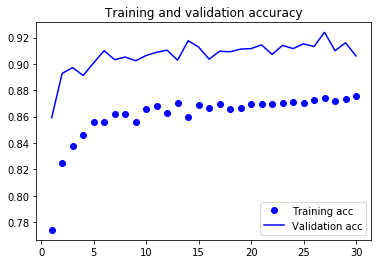

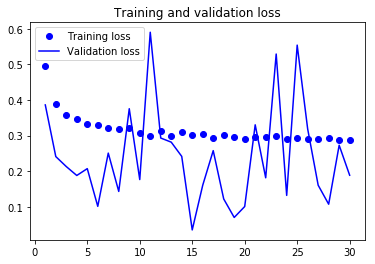

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, 31)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [19]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [20]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 9,732,929
Trainable params: 2,097,665
Non-trainable params: 7,635,264
_________________________________________________________________


In [21]:
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.RMSprop(lr = 1e-5), metrics = ['acc'])
history = model.fit_generator(train_generator, steps_per_epoch = 400, epochs = 30, validation_data = validation_generator, validation_steps = 125)


Epoch 1/30
400/400 [==============================] - 78s 194ms/step - loss: 0.2818 - acc: 0.8795 - val_loss: 0.0328 - val_acc: 0.9252
Epoch 2/30
400/400 [==============================] - 79s 197ms/step - loss: 0.2507 - acc: 0.8963 - val_loss: 0.0250 - val_acc: 0.9324
Epoch 3/30
400/400 [==============================] - 79s 197ms/step - loss: 0.2331 - acc: 0.9001 - val_loss: 0.1549 - val_acc: 0.9136
Epoch 4/30
400/400 [==============================] - 88s 221ms/step - loss: 0.2115 - acc: 0.9141 - val_loss: 0.2479 - val_acc: 0.9516
Epoch 5/30
400/400 [==============================] - 82s 205ms/step - loss: 0.1950 - acc: 0.9191 - val_loss: 0.1611 - val_acc: 0.9420
Epoch 6/30
400/400 [==============================] - 81s 202ms/step - loss: 0.1990 - acc: 0.9161 - val_loss: 0.0405 - val_acc: 0.9416
Epoch 7/30
400/400 [==============================] - 81s 202ms/step - loss: 0.1753 - acc: 0.9266 - val_loss: 0.2769 - val_acc: 0.9412
Epoch 8/30
400/400 [==============================] - 8

In [22]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size = (150, 150),
                                                  batch_size = 20,
                                                  class_mode = 'binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps = 100)
print('test acc:', test_acc)

Found 4000 images belonging to 2 classes.
test acc: 0.9474999904632568
